In [7]:
%load_ext autoreload
%autoreload 2
import sys,os
sys.path.append('../')   
import numpy as np
from model.gaussianNoisePreferenceFull import  gaussianNoisePreference
from model.PlackettLuceGP import PlackettLuceGP
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from utility import  paramz
from kernel.jaxrbf import RBF
from kernel.jaxlinear import Linear
# for plotting
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import multivariate_normal

def compute_mostprobable(Xpred, mean,Sigma,nsamples=100000):
    ss=multivariate_normal.rvs(mean[:,0],Sigma, nsamples).T
    u1 = ss[0:Xpred.shape[0]]
    u2 = ss[Xpred.shape[0]:Xpred.shape[0]*2]
    u3 = ss[Xpred.shape[0]*2:Xpred.shape[0]*3]
    u4 = ss[Xpred.shape[0]*3:Xpred.shape[0]*4]
    u5 = ss[Xpred.shape[0]*4:Xpred.shape[0]*5]
    u6 = ss[Xpred.shape[0]*5:]
    AllHtab=[]
    Htab={}
    for i in range(u1.shape[0]):
        for ind in range(u1.shape[1]):
            inds=np.argsort(-np.hstack([u1[i,ind],u2[i,ind],u3[i,ind],u4[i,ind],u5[i,ind],u6[i,ind]]))
            keys = ''.join(inds.astype(str).tolist())
            if keys in Htab.keys():
                Htab[keys]=Htab[keys]+1
            else:
                Htab[keys]=1
        AllHtab.append([int(v) for v in max(Htab, key=Htab.get)])
    return AllHtab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Game dataset
We consider the results of a survey among 91 Dutch students: . This survey considered the purchase of a new gaming platform and students were required to rank six  options: the Xbox, PlayStation, GameCube, PlayStation Portable, Game Boy, and a regular PC. Additionally, we know (1) their age; (2) which of the 6 platforms the student owns; (3) the average number of hours that each student spends on gaming each week.  As an example, the results of the survey for three students with age 33, 19 and 18 is shown below.

In [4]:
df = pd.read_csv("datasets/Game.csv",index_col=0)#
df.head(3)

,ch.Xbox,ch.PlayStation,ch.PSPortable,ch.GameCube,ch.GameBoy,ch.PC,own.Xbox,own.PlayStation,own.PSPortable,own.GameCube,own.GameBoy,own.PC,age,hours
1,2,1,3,5,6,4,0,1,0,0,0,1,33,2.00
2,4,2,3,5,6,1,0,1,0,0,0,1,19,3.25
3,3,1,2,4,6,5,0,1,0,0,0,1,18,4.00


Since these are ranked data, we can use `PlackettLuceGP` to predict their ranking. There are 6 different labels (Xbox, PlayStation, GameCube, PlayStation Portable, Game Boy) and the subject's covariates are `age`, `hours`  and `own`. For instance, for the first subject (age=33, hours=2, own=$\{$PC,PlayStation$\}$), the ranking is  PlayStation, Xbox, PlayStation Portable, PC, GameCube and Game Boy. Given the covariates of a subject 

Given the covariates of a subject 
$$
{\bf x}=[\texttt{ownGameBoy},
\texttt{ownGameCube},
\texttt{ownPC},
\texttt{ownPlayStation},
\texttt{ownPSPortable},
\texttt{ownXbox},
\texttt{age},
\texttt{hours}
],
$$
the goal is to learn their gaming platforms ranking. This can be accomplished by learning the utilities 
$$
{\bf u}({\bf x})=[u_\texttt{GameBoy}({\bf x}),
u_\texttt{GameCube}({\bf x}),
u_\texttt{PC}({\bf x}),
u_\texttt{PlayStation}({\bf x}),
u_\texttt{PSPortable}({\bf x}),
u_\texttt{Xbox}({\bf x})
].
$$
In this case, we have directly used a nonlinear utility in the covariates by setting a RBF kernel for each GP (one for each label). We have partitioned the dataset  into 90\% for training and 10\% for testing, and we computed the predicted ranking for the students in the test set. 

In [22]:
cols_cov=['own.Xbox', 'own.PlayStation', 'own.PSPortable',
       'own.GameCube', 'own.GameBoy', 'own.PC', 'age', 'hours']
cols_rank=['ch.Xbox', 'ch.PlayStation', 'ch.PSPortable', 'ch.GameCube',
       'ch.GameBoy', 'ch.PC']
n_splits=1
splitter = GroupShuffleSplit(train_size=0.9, n_splits=n_splits, random_state = 123)
split = splitter.split(df, groups=df.index)
Res=[]
for cv in range(n_splits):
    print(cv)
    ind_train, ind_test = next(split)
    df_train = df.iloc[ind_train,:].reset_index(drop=True)
    df_test  = df.iloc[ind_test,:].reset_index(drop=True)
    X_tr = df_train[cols_cov].values#covariates
    Y_tr = np.argsort(df_train[cols_rank].values,axis=1)# ranking
    X_te = df_test[cols_cov].values
    Y_te = np.argsort(df_test[cols_rank].values,axis=1)# ranking
    
    scalerx=StandardScaler().fit(X_tr[:,-2:])
    X_trasf_tr = np.hstack([X_tr[:,0:-2],scalerx.transform(X_tr[:,-2:])])
    X_trasf_te = np.hstack([X_te[:,0:-2],scalerx.transform(X_te[:,-2:])])

    latent_dim = 6 #there are 6 labels
    #define data dictionary
    data={'X': X_trasf_tr,
          'Ranking': Y_tr,
              }
    # define kernel and hyperparams
    Kernel = RBF
    params={}
    for i in range(latent_dim):
        if Kernel==RBF:
            params['lengthscale_'+str(i)]={'value':1.0*np.ones(data["X"].shape[1],float), 
                                        'range':np.vstack([[0.1, 5.0]]*data["X"].shape[1]),
                                        'transform': paramz.logexp()}
            params['variance_'+str(i)]={'value':np.array([3]), 
                                        'range':np.vstack([[0.1, 100.0]]),
                                        'transform': paramz.logexp()}
        elif Kernel==Linear:
            params['variance_'+str(i)]={'value':1.0*np.ones(data["X"].shape[1],float), 
                                        'range':np.vstack([[0.1, 5.0]]*data["X"].shape[1]),
                                        'transform': paramz.logexp()}
            params['dummy_'+str(i)]={'value':np.array([1]), 
                                        'range':np.vstack([[0.1, 100.0]]),
                                        'transform': paramz.logexp()}

    
    
    # define preference model 
    model = PlackettLuceGP(data,Kernel,params,latent_dim)
    # compute hyperparameters
    model.optimize_hyperparams(niterations=2000)
    print(model.params)
    # prediction
    Xpred=X_trasf_te
    predictions = model.predict_VI(Xpred)
    #mean utilities
    output = predictions[0]
    #Covariance of the utilities
    Sigma = predictions[1]
    #most probable ordering
    Orderings=compute_mostprobable(Xpred,output,Sigma,nsamples=500000)
    Acc=[]
    for ind in range(Y_te.shape[0]):
        #inds=np.argsort(-np.hstack([u1[ind],u2[ind],u3[ind],u4[ind],u5[ind],u6[ind]]))
        rank_pred=np.unique(Orderings[ind],return_index=True)[1]
        rank_te = np.unique(Y_te[ind],return_index=True)[1]
        Acc.append((stats.kendalltau(rank_pred, rank_te)[0]+1)/2)
    Res.append(np.mean(Acc))
    print(Res)
    
    

        


0
404.3584627845852
5121.573511766255
97088.54895315778
404.3584633402468
736.652593514757


 lower bound 1435.618881385507: 100%|███████| 2000/2000 [08:27<00:00,  3.94it/s]


{'lengthscale_0': {'value': array([1.29786367, 0.25785592, 0.81672563, 7.70356862, 3.04365913,
       0.7883926 , 0.92355097, 0.67420926]), 'range': array([[0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ]]), 'transform': <utility.paramz.logexp object at 0x7f98bf625790>}, 'variance_0': {'value': array([2.5256477]), 'range': array([[1.e-01, 1.e+02]]), 'transform': <utility.paramz.logexp object at 0x7f98f3f1ab10>}, 'lengthscale_1': {'value': array([1.66342686, 0.72829076, 0.21869571, 0.53656264, 0.9130278 ,
       0.6073734 , 0.51942514, 0.90149718]), 'range': array([[0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ],
       [0.1, 5. ]]), 'transform': <utility.paramz.logexp object at 0x7f98bf58bed0>}, 'variance_1': {'value': array([3.8916591]), 'range': array([[1.e-01, 1.e+02]]), 'transform': <utility.paramz.logexp object 

To produce an ordering of the gaming platforms, we can sample from the joint distribution of the 6 utilities and compute the most probable ordering as shown hereafter for an example.

In [23]:
Orderings=compute_mostprobable(Xpred,output,Sigma,nsamples=500)
Orderings

[[0, 5, 1, 2, 4, 3],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [1, 0, 5, 2, 3, 4],
 [5, 0, 1, 2, 3, 4]]

Text(0, 0.5, 'Posterior')

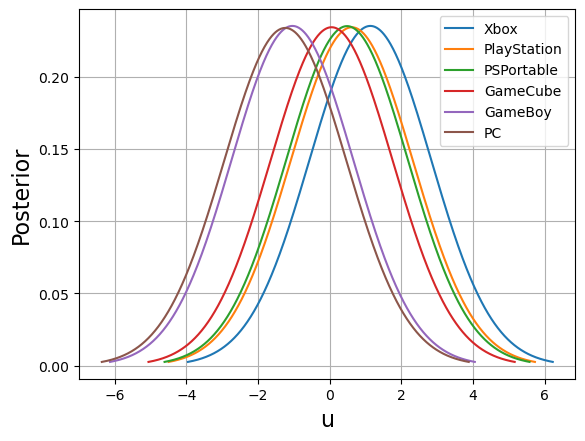

In [24]:
from scipy.stats import norm, multivariate_normal
u1 = output[0:Xpred.shape[0],:]
u2 = output[Xpred.shape[0]:Xpred.shape[0]*2,:]
u3 = output[Xpred.shape[0]*2:Xpred.shape[0]*3,:]
u4 = output[Xpred.shape[0]*3:Xpred.shape[0]*4,:]
u5 = output[Xpred.shape[0]*4:Xpred.shape[0]*5,:]
u6 = output[Xpred.shape[0]*5:,:]
Sigma1 = Sigma[0:Xpred.shape[0],0:Xpred.shape[0]]
Sigma2 = Sigma[Xpred.shape[0]:Xpred.shape[0]*2,Xpred.shape[0]:Xpred.shape[0]*2]
Sigma3 = Sigma[Xpred.shape[0]*2:Xpred.shape[0]*3,Xpred.shape[0]*2:Xpred.shape[0]*3]
Sigma4 = Sigma[Xpred.shape[0]*3:Xpred.shape[0]*4,Xpred.shape[0]*3:Xpred.shape[0]*4]
Sigma5 = Sigma[Xpred.shape[0]*4:Xpred.shape[0]*5,Xpred.shape[0]*4:Xpred.shape[0]*5]
Sigma6 = Sigma[Xpred.shape[0]*5:,Xpred.shape[0]*5:]
ind=[2]
col=['C0','C1','C2','C3','C4','C5']
gaming=['Xbox', 'PlayStation', 'PSPortable', 'GameCube','GameBoy', 'PC']
j=-1
for i in ind:
    
    for util,Sigm in zip([u1,u2,u3,u4,u5,u6],[Sigma1,Sigma2,Sigma3,Sigma4,Sigma5,Sigma6]):
        j=j+1
        m1=util[i]
        s1=np.sqrt(Sigm[i,i])
        xx = np.linspace(m1 - 3*s1,m1+3*s1, 1000)
        yy = norm.pdf(xx, m1, s1)
        plt.plot(xx, yy,color=col[j],label=gaming[j])
plt.xlabel("u",fontsize=16)
plt.legend()
plt.grid()
plt.ylabel("Posterior",fontsize=16)
#plt.savefig("figures/gamingu2.pdf")
